==============================================================================================
## Practicum 5: Image search using textures
==============================================================================================



The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.


## Delivery

All code sould be commented in English. Answers of the questions should be given in English too.

Compressed file **P5_Student1_Student2.zip** that includes:
- The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
- The images used that are not provided in P5.zip.

**Deadline (Campus Virtual): Desember 12th, 11:00 p.m.** 


 The function should return a feature vector obtained by averaging each filter response on the image.  

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [1]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
import os

import matplotlib.pyplot as plt

In [2]:
path = "./images/texturesimages/buildings/"
building_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/forest/"
forest_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/sunset/"
sunset_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

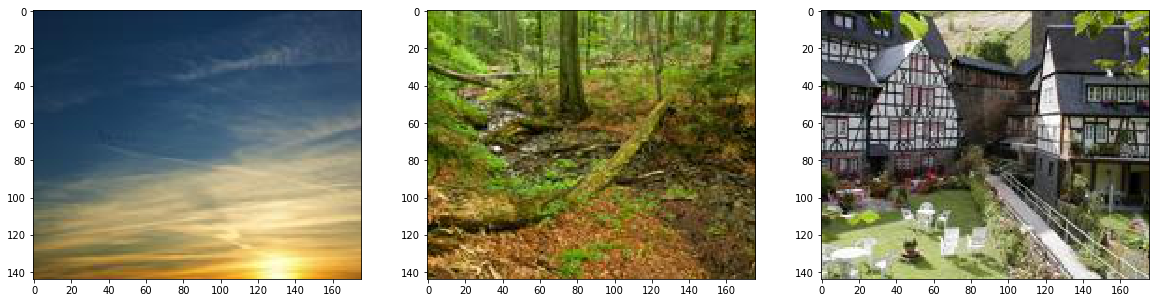

In [3]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(sunset_images[0])
ax[1].imshow(forest_images[0])
ax[2].imshow(building_images[0])
plt.show()

In [4]:
len(sunset_images), len(forest_images), len(sunset_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [5]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [6]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

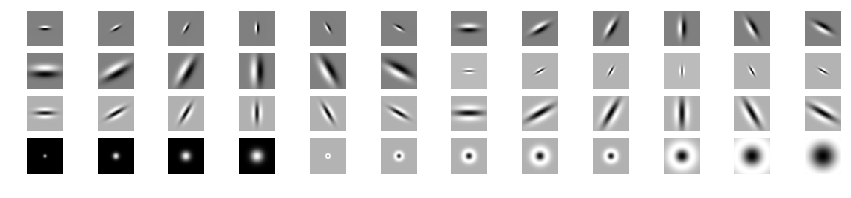

In [7]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


## Exercise 5.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png">


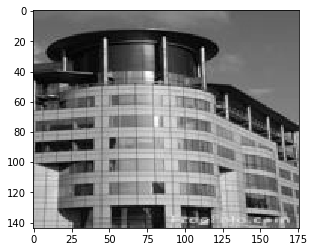

In [8]:
im = skimage.color.rgb2gray(building_images[6])
plt.imshow(im, cmap="gray")

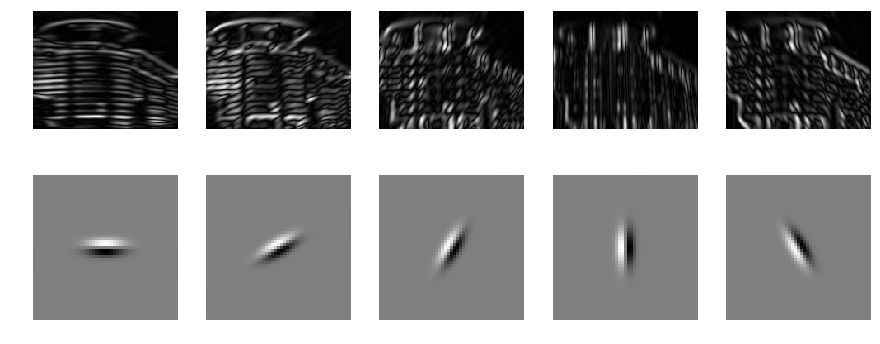

In [9]:
from scipy.ndimage.filters import convolve
def visualize_features(im,  filter_bank, n_filters=5):
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,6))
    for i in range(n_filters):
        convolved_im = abs(convolve(im,filter_bank[:,:,i]))
        ax[0][i].imshow(convolved_im, cmap = 'gray')
        ax[0][i].set_axis_off()
        ax[1][i].imshow(filter_bank[:,:,i], cmap = 'gray')
        ax[1][i].set_axis_off()
    plt.show()

visualize_features(im, filter_bank)



## Exercise 5.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [10]:
im = skimage.color.rgb2gray(building_images[1])

def features_from_filter_bank(image, filter_bank, n_filters):
    ## Complete this function
    im_conv = np.zeros(image.shape)
    features_for_im = np.zeros(n_filters)
    for i in range(n_filters):
        im_conv = abs(convolve(skimage.color.rgb2gray(image),filter_bank[:,:,i]))
        im_mean = np.mean(im_conv)
        features_for_im[i] = im_mean
    return features_for_im

features_for_im = features_from_filter_bank(im, filter_bank, n_filters)

## Exercise 5.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [11]:
all_images = building_images + forest_images + sunset_images

In [11]:
%%time

def get_class_features(all_images,  filter_bank):
    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors=np.zeros((n_images,n_filters))
    for i in range(n_images):  
        im_vector = features_from_filter_bank(all_images[i], filter_bank, n_filters)
        all_feature_vectors[i,:] = im_vector
    return all_feature_vectors

all_feature_vectors=get_class_features(all_images,  filter_bank)

CPU times: user 8min 29s, sys: 24 s, total: 8min 53s
Wall time: 9min 1s


In [13]:
np.save("all_feature_vectors.npy", all_feature_vectors)

In [12]:
all_feature_vectors = np.load("all_feature_vectors.npy")

## Exercise 5.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


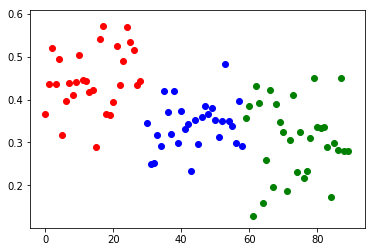

In [13]:
def visualize_features(k, all_feature_vectors):
    vector = all_feature_vectors[:,k] #we retrieve the column k from the feature vectors table
    max_value = np.argmax(vector) #we find the maximum value of that column 
    
    fig, ax = plt.subplots()
    x = np.arange(0,90)
    y = vector
    ax.scatter(x[:29],y[:29], color='r')
    ax.scatter(x[30:59],y[30:59], color = 'b')
    ax.scatter(x[59:],y[59:], color = 'g')
    plt.show()
    
#visualize_features(25, all_feature_vectors)    
visualize_features(41, all_feature_vectors)    





#### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$


## Exercise 5.5 Retrieving the most similar images



Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar images (according to the l2 norm) and the distances from the closest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

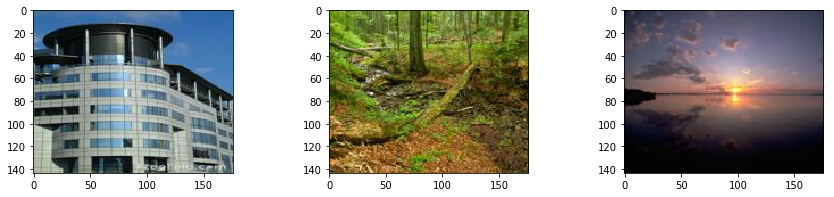

In [110]:
X = np.array(all_feature_vectors)
ind_1 = 6
ind_2 = 30
ind_3 = 65

query_1 = X[6, :]
query_2 = X[30,:]
query_3 = X[65,:]


# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[6]) 
ax[1].imshow(all_images[30])
ax[2].imshow(all_images[65])

In [111]:
def retrieve_k_images_from_X(query, X, k):
    arr = np.ones(len(X))
    dict_to_sort = {} #as we need the index of the image and the distance, we use dictionary to sort them
    for i in range(len(X)):
        arr[i]= np.linalg.norm(query-X[i]) #we store the distances between the query image and each image
        dict_to_sort[arr[i]] = i #for each distance we store the index it belongs to
    
    sorted_distances = np.sort(np.partition(arr,k+1)[:k+1]) #we sort all the distances and get the k most similar
    result = []
    for distance in sorted_distances:
        result.append(dict_to_sort[distance])
    return result[1:], sorted_distances[1:] 



In [126]:
"""This function plots the K most similar images for a query image"""
def display_k_images_for_query(index,query,all_images,X,k):
    closest_images, distances = retrieve_k_images_from_X(query,X,k)

    f, axarr = plt.subplots(1,k+1)
    f.set_size_inches(20,7)
    axarr[0].imshow(all_images[index], cmap = 'gray')
    axarr[0].set_axis_off()
    axarr[0].set_title("Query Image")
    for i in range(k):
        axarr[i+1].imshow(all_images[closest_images[i]], cmap = 'gray')
        axarr[i+1].set_axis_off()
        axarr[i+1].set_title(str(i+1) + " Similar Image")
    plt.show()

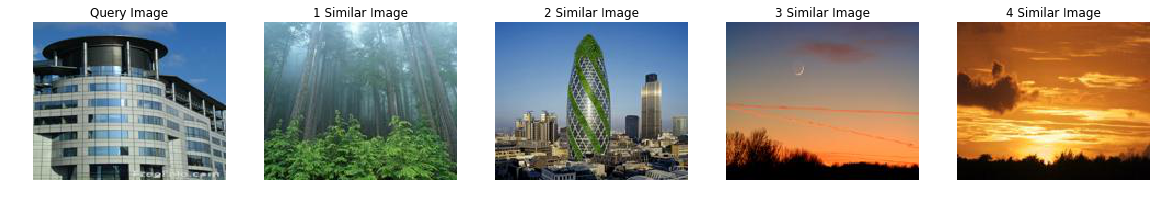

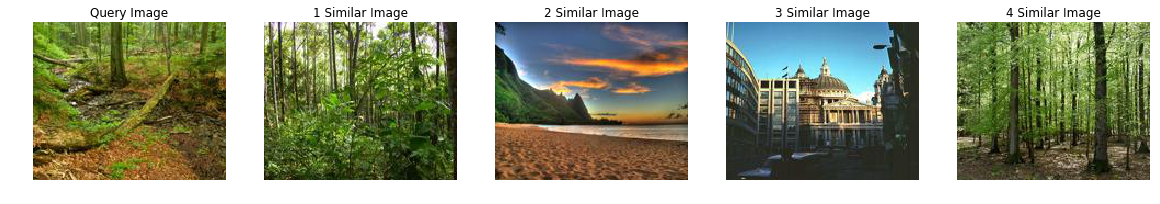

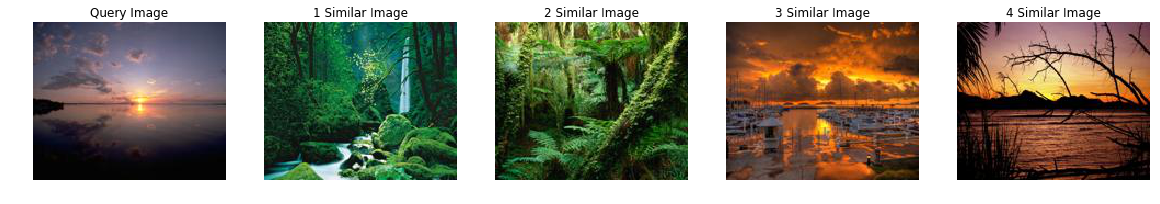

In [133]:

display_k_images_for_query(6,query_1,all_images,all_feature_vectors,4)
display_k_images_for_query(30,query_2,all_images,all_feature_vectors,4)
display_k_images_for_query(65,query_3,all_images,all_feature_vectors,4)

## Exercise 5.6 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.

- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?


In [17]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)


In [129]:
def accuracy(X, class_labels, k, query, class_query):
    acc = 0
    k_images, distances = retrieve_k_images_from_X(query,X,k)
    for index in k_images:
        if class_labels[index] == class_query:
            acc += 1
    
    return acc/k




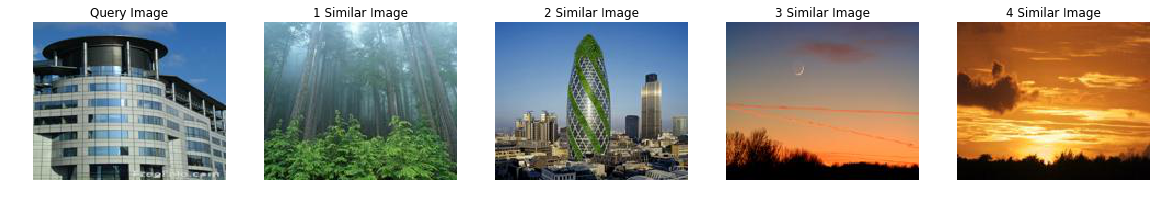

Accuracy: 0.25


In [130]:
query = all_feature_vectors[6]
acc = accuracy(X, class_labels, 4, query, 0)
display_k_images_for_query(6,query,all_images,X,4)
print("Accuracy:", acc)

## Exercise 5.7 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated by color features. What is the dimension of the new feature space?


In [32]:

def lm_features_rgb(image, filter_bank):

    n_filters = filter_bank.shape[2]
    
    
    features_for_im_r = np.zeros(n_filters)
    features_for_im_g = np.zeros(n_filters)
    features_for_im_b = np.zeros(n_filters)
    
    for i in range(n_filters):
        #We convolve each channel of the images and the mean
        im_conv_r = abs(convolve(image[:,:,0],filter_bank[:,:,i]))
        im_conv_g = abs(convolve(image[:,:,1],filter_bank[:,:,i]))
        im_conv_b = abs(convolve(image[:,:,2],filter_bank[:,:,i]))
        
        im_mean_r = np.mean(im_conv_r)
        im_mean_g = np.mean(im_conv_g)
        im_mean_b = np.mean(im_conv_b)
        
        features_for_im_r[i] = im_mean_r
        features_for_im_g[i] = im_mean_g
        features_for_im_b[i] = im_mean_b
    
    return np.concatenate((features_for_im_r,features_for_im_g,features_for_im_b)).reshape(3*len(features_for_im_r),1)

In [33]:
%%time 
lm_rgb_features = lm_features_rgb(all_images[0], filter_bank)

CPU times: user 18.3 s, sys: 927 ms, total: 19.3 s
Wall time: 19.9 s



## Exercise 5.8 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.
You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [67]:
from joblib import Parallel,delayed
def get_all_lm_rgb(all_images,filter_bank):
    X_lm_rgb = np.array(len(all_images))
    return Parallel(n_jobs=2)(delayed(lm_features_rgb)(image, filter_bank) for image in all_images)
    

In [68]:
%%time
X_lm_rgb = get_all_lm_rgb(all_images,filter_bank)

CPU times: user 643 ms, sys: 183 ms, total: 826 ms
Wall time: 14min 58s


In [75]:
np.save("x_lm_rgb.npy", X_lm_rgb)

In [76]:
X_lm_rgb = np.load("x_lm_rgb.npy")

## 5.9 Compute the accuracy of the method using lm rgb features

Use the function implemented in 5.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

In [69]:
# compute (X_lm_rgb) and cast it as array
X_lm_rgb = np.array(X_lm_rgb)

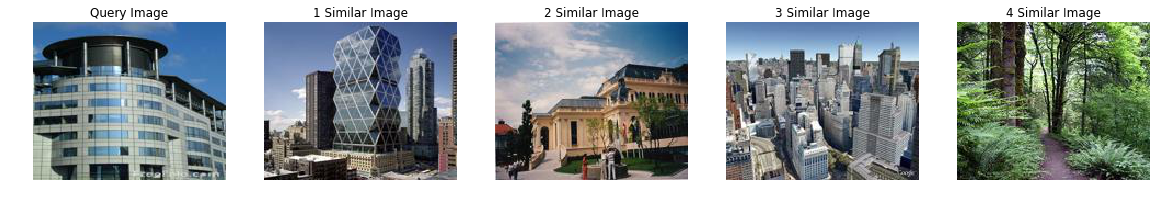

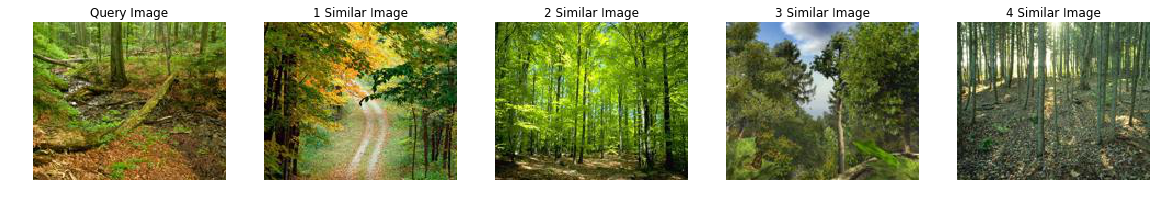

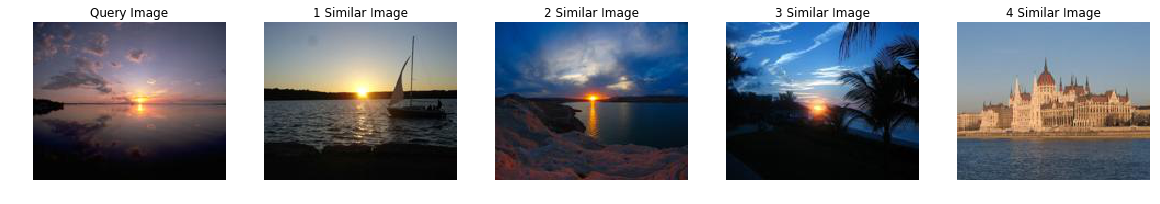

In [131]:
display_k_images_for_query(6,X_lm_rgb[6],all_images,X_lm_rgb,4)
display_k_images_for_query(30,X_lm_rgb[30],all_images,X_lm_rgb,4)
display_k_images_for_query(65,X_lm_rgb[65],all_images,X_lm_rgb,4)

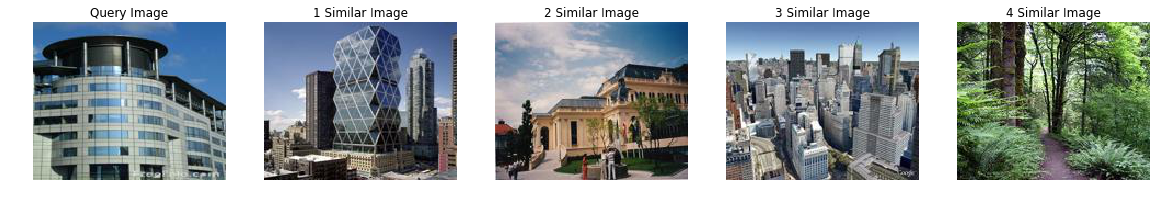

Accuracy: 0.75


In [132]:
query = X_lm_rgb[6]
acc = accuracy(X_lm_rgb, class_labels, 4, query, 0)
display_k_images_for_query(6,query,all_images,X_lm_rgb,4)
print("Accuracy:", acc)